Homework 3 — (15 points)
======
### What to hand in
You are to submit the following things for this homework:
1. A Jupyter notebook containing all code and output (figures and audio). I should be able to evaluate the file to reproduce all output. 
1. Any other data that we tell you to save to a file (e.g. audio files).

### How to hand it in
To submit your lab:
1. Compress all of the files specified into a .zip file. 
1. Name the file in the following manner, firstname_lastname_hw1.zip. For example, Bryan_Pardo_hw1.zip. 
1. Submit this .zip file via Canvas

## Run this code block 1st, to import the needed packages

In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (eg random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline



/home/harntson/miniconda2/envs/eecs352/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


## Some Helpful Code

In [145]:

from scipy.fftpack import fft
from scipy.signal import hann

def wavwrite(filepath, data, sr, norm=True, dtype='int16',):
    '''
    Write wave file using scipy.io.wavefile.write, converting from a float (-1.0 : 1.0) numpy array to an integer array
    
    Parameters
    ----------
    filepath : str
        The path of the output .wav file
    data : np.array
        The float-type audio array
    sr : int
        The sampling rate
    norm : bool
        If True, normalize the audio to -1.0 to 1.0 before converting integer
    dtype : str
        The output type. Typically leave this at the default of 'int16'.
    '''
    if norm:
        data /= np.max(np.abs(data))
    data = data * np.iinfo(dtype).max
    data = data.astype(dtype)
    sp.io.wavfile.write(filepath, sr, data)
    
#-----------------------------------------------------------
# Here's an stft implementation. Yes, it doesn't bother to get the last little bit of audio.
   
def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = 1 + length_to_cover_with_hops/hop_size;
    
    # make our window function
    if window_type == 'hann':
        window = hann(window_size)
    elif window_type=='rectangular':
        window = np.ones(window_size)
    else:
        raise Exception('Invalid window type. Must be "hann" or "rectangular".')
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft)

#-----------------------------------------------------------
# here's a spectrogram implementation

def spectrogram(signal, window_size, hop_size, sample_rate, window_type = 'hann', display = True ):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This creates a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    It then creates a magnitude spectrogram of the signal and plots it on the screen.
    Here, the vertical dimension is frequency (in Hz), the horizontal dimension is time
    (in seconds), brightness corresponds to amplitude (in dB). Only frequencies up to
    the Nyquist rate are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    window_type: a string specifying one of two "hann" or "rectangular"
    display: a bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    sgram:  a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram
           sgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency of analysis in Hz, up to the nyquist frequency
           
    Calling Example
    ---------------
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )

    """ 

    # get the stft
    X = stft(signal, window_size, hop_size, window_type)

    # figure out what my window start times are
    times = np.arange(len(X))
    hop_in_secs = hop_size/(1.0 * sample_rate)
    times = times * hop_in_secs
    
    # chop off everything above the nyquist rate & rotate for display    
    X = np.rot90(X,3)
    sgram = np.array(X[0:len(X)/2])

    # figure out what my frequencies of analysis are..
    analysis_f0 = float(sample_rate)/window_size
    freqs = np.arange(len(sgram)) * analysis_f0
    
    # turn the complex values into magnitudes and putit into a log scale 
    sgram = np.abs(sgram) + 0.00000000000001  # this prevents taking the log of 0
    log_sgram = 20 * np.log10(sgram)
 
    # plot the spectrum 
    if display: 
        plt.figure()
        x_coord = np.tile(times,(len(freqs),1)) 
        x_coord = np.fliplr(x_coord)
        y_coord = np.tile(freqs,(len(times),1))
        y_coord = np.rot90(y_coord,3)
        
        plt.pcolor(x_coord,y_coord,log_sgram)
        # set the limits of the plot to the limits of the data
        plt.axis([x_coord.min(), x_coord.max(), y_coord.min(), y_coord.max()])

        plt.title('Magnitude Spectrogram in dB')
        plt.xlabel('time in seconds')
        plt.ylabel('frequency in Hz')
        cbar = plt.colorbar()
        plt.show()

    return np.rot90(log_sgram,1), times, freqs
#--------------------------------------
# A couple of helper functions to make mels into frequencies and vice versa

def mel2freq(mel):
    freq = 700.0 * (-1.0 + 10.0**(mel/2595.0))
    return freq

def freq2mel(freq):
    x = 1.0 + freq/700.0
    mel = 2595 * np.log10(x)
    return mel

#-----------------------------------------------------------
# Exactly what it says it is...

def make_triangular_filters(cfreqs, freqs ):
    """
    Computes a set of "filters" to apply to an STFT to change its frequency scaling.
    This takes an array of center frequencies (cfreqs) and a set of frequencies of 
    analysis (freqs) as input, both coded in Hz.  It will return a 2-D numpy array 
    filters[c][f], where c is the index number of a center frequency in cfreqs and 
    f is the index to a frequency in freqs and the value in filters[c][f] is a number 
    between 0 and 1 that represents how sensitive this filter is to that frequency.  
    Filters are triangular, with a linear decrease in sensitivity from the center 
    frequency (sensitivity = 1) down to a sensitivity of 0 by the center frequency 
    of each adjacent freqency.
    
    Input Parameters
    ----------------
    cfreqs: a 1-D python array of center frequencies measured in Hz
    freqs:   a 1-D python array of frequencies for whom we need to calculate the sensitivity
             of each filter. 
    
    Returns
    -------
    filters: a 2-D numpy array, where c is the index number of a center frequency in 
            cfreqs and f is the index to a frequency in freqs and the value in filters[c][f] 
            is a number between 0 and 1 that represents how sensitive this filter is to 
            that frequency.
    """
     
    assert min(freqs)<=min(cfreqs) and max(freqs)>=max(cfreqs), "cfreqs range must be within freqs range."

    filters = np.zeros((len(cfreqs), len(freqs)))
    
    for c in range(0,len(cfreqs)):
        if c==0: 
            # if we're on the first cfreq, use min(freq) for the low
            low_freq = min(freqs)
            high_freq = cfreqs[c+1]
        elif c==(len(cfreqs)-1):
            # if we're on the last cfreq, use max(freq) for the high
            low_freq = cfreqs[c-1]
            high_freq = max(freqs)
        else:
            low_freq = cfreqs[c-1]
            high_freq = cfreqs[c+1]
  
        for f in range(len(freqs)):
            
            if (freqs[f]> cfreqs[c]):
                x = freqs[f]
                b = -high_freq / (cfreqs[c]-high_freq) # offset
                a = 1./(cfreqs[c]-high_freq) # slope
                filters[c][f] = max([a*x+b,0.])
            elif (freqs[f]< cfreqs[c]):
                x = freqs[f]
                b = -low_freq / (cfreqs[c]-low_freq) # offset
                a = 1./(cfreqs[c]-low_freq) # slope
                filters[c][f] = max([a*x+b,0.])
            else:
                filters[c][f] = 1.0
    return filters

#### 1. (2 points) Make a log spectrogram function that lets you use either log2 spacing or mel frequency spacing..  

$m = 2595log_{10}(1+\frac{f}{700})$

(1) Douglas O'Shaughnessy (1987). Speech communication: human and machine. Addison-Wesley. p. 150. ISBN 978-0-201-16520-3.

In [280]:
def log_spectrogram(signal, window_size, hop_size, sample_rate, num_channels, channel_spacing = 'mel', display = True ):
    """
    Builds a mel-frequency spectrogram. Computes the short term fourier transform of a 1-D numpy array 
    (the signal). It then creates a magnitude spectrogram of the signal and then remaps the energy num_channels
    frequency bins, spaced evenly in the log (or mel) frequency domain between the top key of the piano (4186 Hz) and 
    the bottom key of the piano (27.5 Hz). The vertical dimension is the index number of 
    the frequency channel. The horizontal dimension is time(in seconds), brightness corresponds to 
    amplitude (in dB). Only frequencies up to the top of the piano are displayed.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    num_channels: how many frequency bins to put the energy into
    channel_spacing: if 'mel', then space evenly in the mel range. Else, evenly in log2(freq)
            *NOTE* if you pick 88 channels and log2 spacing, this places a bin at each piano key
    display: a bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    lgram: a 2-D numpy array of real-valued numbers that contains the magnitude spectrogram.
           lgram[t,f] is the magnitude at time t and frequency f. This only contains values
           up to the pitch note of the piano (4186 Hz)
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    freqs: a 1-D numpy array  of non-negative real values. freqs[f] gives the fth
           frequency bin in Hz. These are spaced evenly in the log2 of the frequency in Hz,
           with 12 to an octave. 
           
    Calling Example
    ---------------
    lgram,times,freqs = log_spectrogram(signal, window_size, hop_size, sample_rate, num_channels )

    """ 
    # your code goes here
    # Get linearly spaced spectrogram
    sgram,times,freqs_init = spectrogram(signal, window_size, hop_size, sample_rate, display=True )
    
    # Range of center frequencies is piano keyboard
    bottom_note = 27.5
    top_note = 4186.
    
    # Calculate channel frequencies
    if channel_spacing == 'mel':
        # mel spacing
        mel_top = 2595*np.log10(1 + top_note/700.)
        mel_bottom = 2585*np.log10(1 + bottom_note/700.)
        # Evenly spaced center frequencies
        mels = np.linspace(mel_bottom, mel_top, num_channels)
        # Convert back to Hz
        freqs = (10**(mels/2595.) - 1)*700
        
    else:
        # log2 spacing
        log2_top = np.log2(top_note)
        log2_bottom = np.log2(bottom_note)
        # Evenly spaced center frequencies
        logs = np.linspace(log2_bottom, log2_top, num_channels)
        # Convert back to Hz
        freqs = 2**logs
    
    # Create filterbank
    filters = make_triangular_filters(freqs, freqs_init)
    
    # Apply filters
    lgram = np.dot(filters, sgram.transpose())
    #lgram = lgram.transpose()
    
    # Plot log spectrogram
    if display==True:
        plt.imshow(lgram, origin='lower')
        
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.title('Log Spectrogram')
        #plt.yticks(freqs)
        #plt.xticks(times[0::5])
        #plt.axis([0, max(times), 0, len(freqs)])
        plt.colorbar()
        plt.show()

    return lgram, times, freqs

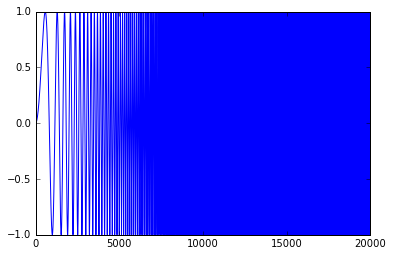

Logarithmic chirp--channels spaced evenly in Mels


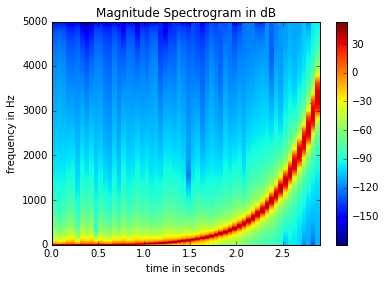

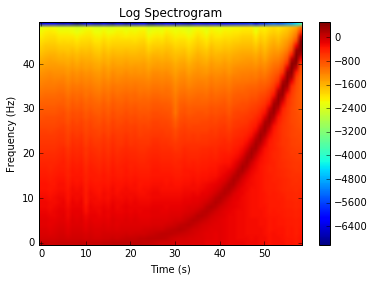

Logarithmic chirp--channels spaced evenly in Log2


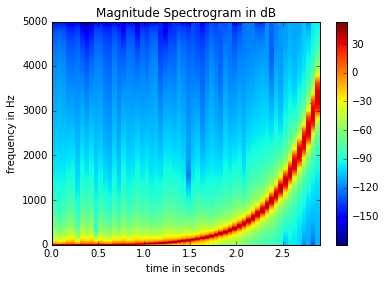

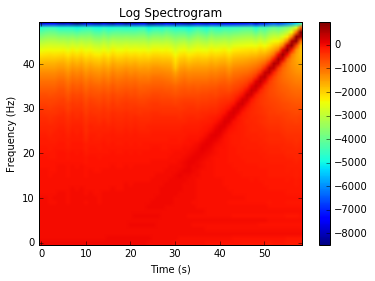

In [282]:
# you should probably write something to test your code here.

# 3 second signal
sr = 10000
dt = np.arange(0,3.*sr)/sr

# sine function
sin = lambda f: np.sin(2. * np.pi * f * dt)

# Linear chirp signal
f = 200.*dt
lin_chirp = sin(f)

# Logarithmic chirp signal
f = 8.**dt
log_chirp = sin(f)

plt.plot(chirp)
plt.show()

print "Logarithmic chirp--channels spaced evenly in Mels"
lgram, times, freqs = log_spectrogram(log_chirp, 1000, 500, sr, 50, channel_spacing='mel')

print "Logarithmic chirp--channels spaced evenly in Log2"
lgram, times, freqs = log_spectrogram(log_chirp, 1000, 500, sr, 50, channel_spacing='log2')



### 2. ( 2 points) Make a chromagram. 

In [347]:
def chromagram(signal, window_size, hop_size, sample_rate, bins_per_pitchclass = 10, display = True):
    """
    Computes a SIMPLE chromagram of the signal and plots it on the screen. By SIMPLE chromagram,
    I mean that each chroma bin only gets energy from frequencies that fall within the width of the bin.
    Another way of putting that is: Only energy around powers of 2 of the same frequencies share a chroma bin.
    Another way of putting that is no energy from odd harmonics placed in a bin. 
    
    Here, the vertical dimension is chroma from 0 to 1 (AKA pitch class put on a scale from 0 to 1), 
    the horizontal dimension is time (in seconds), brightness corresponds to amplitude (in dB).
    
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    bins_per_pitchclass: a positive integer specifying how many bins each pitchclass will contain
    display: bool. if set to True, it displays the chromagram on the screen
    
    Returns
    -------
    an output tuple with 3 items
    
    cgram:  a 2-D numpy array of real-valued numbers that contains the magnitude chromagram
           cgram[t,c] is the magnitude at time t and chroma c. This only contains values
           up to the nyquist frequency
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
    chroma: a 1-D numpy array  of non-negative real values in the range 0 to 1. chroma[c] 
            gives the cth chroma bin 
  
    Calling Example
    ---------------
    cgram,times,chroma = chromagram(signal, window_size, hop_size, sample_rate, bins_per_pitchclass)
        
    """
    # your code goes here
    
    # Make spectrogram
    sgram,times,freqs = spectrogram(signal, window_size, hop_size, sample_rate )
    sgram = np.abs(sgram)
    
    # Make chroma bins
    chroma = np.linspace(0,1.0,12*bins_per_pitchclass)
    
    # Get chroma of each frequency
    freqs = freqs + 0.0000001 # Avoid log2(0)
    freq_chroma = np.log2(freqs) - np.floor(np.log2(freqs))
    # Bin chromas
    indexs = np.digitize(freq_chroma, chroma)
    
    # Generate empty chromagram
    cgram = np.zeros((len(times), len(chroma)))
    
    # For each timestep in the spectrogram, find the chroma of each frequency
    for t in range(len(times)):
        # Sum the amplitudes of all frequencies with the same chroma bin
        for f in range(len(freqs)):
            cgram[t][indexs[f]] = cgram[t][indexs[f]] + sgram[t][f]
    
    print len(chroma)
    print len(times)
    print cgram.shape
    
    if display==True:
        plt.pcolor(times, chroma, cgram.transpose())
        plt.axis([0, max(times), 0, max(chroma)])
        plt.xlabel("Time (s)")
        plt.ylabel("Pitch Class")
        labels = ['C', 'B', 'Bb', 'A', 'G#', 'G', 'F#', 'F', 'E', 'Eb', 'D', 'C#']
        plt.yticks(np.linspace(0,1,12), labels)
        plt.title("Chromagram")
        plt.colorbar()
        plt.show()
        #plt.imshow(cgram.transpose(), origin='lower')
                     
    return cgram,times,chroma



0.781359713525


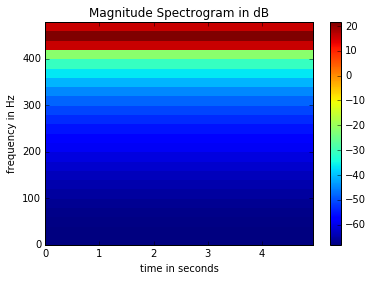

120
199
(199, 120)


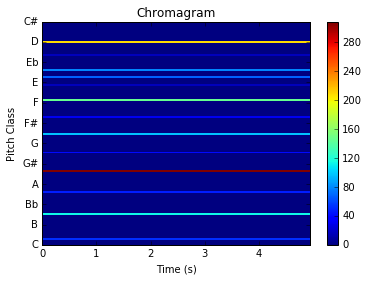

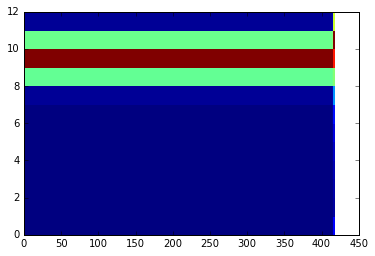

In [349]:
# do yourself a favor and write something to test your chromagram here.

sr = 1000
dt = np.arange(0,5.*sr)/sr
wave = np.sin(2*np.pi*440.*dt)

print np.log2(440.)-np.floor(np.log2(440.))

cgram, times, chroma = chromagram(wave, 50, 25, sr)

S = np.abs(librosa.stft(wave, n_fft=50))
lib_chroma = librosa.feature.chroma_stft(S=S, sr=sr)
plt.pcolor(lib_chroma)

#### 3. (2 point) Make a mel-frequency cepstrogram.  In lecture we mentioned the plain (not mel frequency) cepstrum of a time-domain signal $s$ can be calculated as follows:

$ cepstrum = ifft(log|fft(s)|)$

#### For audio processing, we typically don't use the FFT, but the mel-spectrogram. This means we've removed the frequencies above the Nyquist rate and therefore, things can get a little bit weird when taking the inverse FFT. A very common approach to dealing with this weirdness is to use an alternate transform called the Discrete Cosine Transform (DCT). You don't have to understand the details for this assignment , but you can find out more about cesptrums in the paper reading coming up in the 2nd half of the class.  Anyhow, now the cepstrum looks more like this:

1. Get the spectrum S = fft(s)
2. make a mel-spaced magnitude spectrum M from S, discarding frequencies above Nyquist
3. make M' = log(M)
4. do DCT(M') 

#### This is the approach we'd like you to take in making a mel-frequency cepstrogram. 

#### You can find a DCT implementation to use here:
http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.fftpack.dct.html


In [7]:
def mf_cepstrogram(signal, window_size, hop_size, sample_rate, num_channels, display = True ):
    """
    Builds a mel-frequency cepstrogram. Computes the short term fourier transform of a 1-D numpy array 
    (the signal). It then creates a magnitude spectrogram of the signal and then remaps the energy num_channels
    frequency bins, spaced evenly in the mel frequency domain between the top key of the piano (4186 Hz) and 
    the bottom key of the piano (27.5 Hz). It then takes the DCT of the log of each magnitude spectrum. The 
    vertical dimension is the index number of the cepstral coefficient. The horizontal dimension is time(in seconds), 
    brightness corresponds to magnitude.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    sample_rate: an integer giving the sample rate of the input signal, in Hz
    num_channels: how many mel-spaced frequency bins to put the energy into. 
                This becomes the number of cepstral coefficients.
    display: bool. If set to True, it plots the spectrogram. Else it does not.
    
    Returns
    -------
    an output tuple with 3 items
    
    mfccgram: a 2-D numpy array of real-valued numbers that contains the mel frequency cepstrogram.
           mfccgram[t,c] is the magnitude at time t and cepstral coefficeint c. 
    times: a 1-D numpy array of non-negative real-values that gives the times,  
           times[t] gives the start time of the tth window in seconds
           
    Calling Example
    ---------------
    mfccgram,times = mf_cepstrogram(signal, window_size, hop_size, sample_rate, num_channels)

    """
    # your code goes here
    
    return mfccgram, times

## Starting with Question 4, it is OK to use any function from librosa to do your work.

#### 4. (1 point) The recording "balloon_response.wav" is of a balloon pop recorded in the Garage in front of the class. Assume that the balloon pop was a perfect impulse and that the recording made was a perfect recording of the resulting sound in the room. Explain how to use "balloon_response.wav" to estimate the impulse response of the room and add the sound of the Garage's reverberation to the dry (no reverb) recording "trumpet.wav."

your answer goes here

#### 5. (1 points) Now explain what possible sources of error there that might mess up the approach to estimating the Garage's impulse  response described in Question 4 and how you would go about reducing or eliminating these sources of error in your impulse response estimation.

your answer goes here

#### 6. (2 points)  Below is some code we have provided to estimate the impulse response of the Garage using the double sine sweep we played and recorded. Plot the frequency response function associated with this impulse response function. Plot the frequency response of the impulse response you got using the method in Question 4. Compare them. 

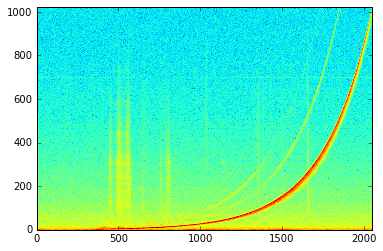

In [8]:
# Since we made double chirp, we know how many samples one chirp (ie one sweep) is.
sweep_length = 2**20

# load the sweep tone played out through the speaker in the Garage
double_sweep,sr = librosa.load('double_chirp_edit.wav', 44100)

# just checking my double sweep is really 2x the sweep length. 
assert(len(double_sweep)/2==sweep_length)

# load the 3rd recording made of the sweep tone made in the Garage
double_sweep_recording3,sr = librosa.load('garage_recordings/double_sweep3.wav', 44100)

# show an stft of the double sweep recorded in the Garage
plt.figure(); plt.imshow(20*np.log10(np.abs(librosa.stft(double_sweep_recording3[sweep_length:2*sweep_length]))),origin='lower',aspect='auto')

# one sweep is half of the original signal.
single_sweep = double_sweep[:sweep_length]

# calculate the impulse response from the 2nd of the two sweeps (ask Mark Cartwright why we use the 2nd one)
ds_response = np.fft.ifft(np.fft.fft(double_sweep_recording3[sweep_length:2*sweep_length]) / np.fft.fft(single_sweep)).real

# shorten the length of the impulse response to be a length I've chosen. Note that it started being 2**20 and now 
# I shortened it to 2**16. Clearly you could shorten it further, if there were some need. What would that do? 
impulse_response_function_length = 2**16
ds_response = ds_response[:impulse_response_function_length]


In [9]:
# your code goes here

#### 7. (2 points) Use the sine sweep derived impulse response to add reverb to "trumpet.wav". Also use the approach you described in Question 4 to add reverb to trumpet.wav. Which sounds better? Note...it is ok for this problem to trim an impulse response or trim the trumpet file a touch so that they are the same length.

In [10]:
# your code goes here

#### 8. (1 point) Go on Youtube and listen to the musical piece "I am sitting in a room" by Alvin Lucier. Research the piece on the web. Give your reaction to the piece. Explain how it was created. 

your answer goes here

#### 9. (2 points) Recreate Alvin Lucier's piece by recording your voice saying the text of the piece ONCE. Then repeatedly use an impulse response function applied to the signal, duplicating the effect of Lucier's piece without having to keep re-recording in the physical world. NOTE you may have issues to deal with in terms of normalization or length of impulse response function vs length of the recording. You're going to have to figure out those out. 

In [11]:
# your code goes here